In [2]:
# Benchmark with CIFAR-10 and pytorch

import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



In [3]:
# create CIFAR-10 dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [4]:
# simple ResNet with layernorm

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.ln1 = nn.LayerNorm([6, 28, 28])
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.ln2 = nn.LayerNorm([16, 10, 10])
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.ln3 = nn.LayerNorm([120])
        self.fc2 = nn.Linear(120, 84)
        self.ln4 = nn.LayerNorm([84])
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.ln1(self.conv1(x))))
        x = self.pool(F.relu(self.ln2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.ln3(self.fc1(x)))
        x = F.relu(self.ln4(self.fc2(x)))
        x = self.fc3(x)
        return x

In [5]:
import torch
from torch.nn import Module, Parameter

class DyT(Module):
    def __init__(self, C, init_α=0.5):
        super().__init__()
        self.α = Parameter(torch.ones(1) * init_α)  # Scalar parameter
        self.γ = Parameter(torch.ones(C))          # Per-channel scaling
        self.β = Parameter(torch.zeros(C))         # Per-channel shift

    def forward(self, x):
        x = torch.tanh(self.α * x)  # Element-wise tanh with scaled input
        return self.γ * x + self.β  # Scale and shift the output

In [15]:
class DyT(torch.nn.Module):
    def __init__(self, C, init_α=0.5):
        super().__init__()
        self.α = torch.nn.Parameter(torch.ones(1) * init_α)  # Scalar
        self.γ = torch.nn.Parameter(torch.ones(C))           # [C]
        self.β = torch.nn.Parameter(torch.zeros(C))          # [C]

    def forward(self, x):
        x = torch.tanh(self.α * x)
        if x.dim() == 4:
            # For 4D input [batch_size, C, H, W], reshape γ and β to [1, C, 1, 1]
            gamma = self.γ.view(1, -1, 1, 1)
            beta = self.β.view(1, -1, 1, 1)
        elif x.dim() == 2:
            # For 2D input [batch_size, C], keep as is
            gamma = self.γ
            beta = self.β
        else:
            raise ValueError(f"Unsupported input dimension: {x.dim()}")
        return gamma * x + beta

In [30]:
# ResNet with

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)    # Input: 3x32x32, Output: 6x28x28
        self.dyt1 = DyT(C=6)               # Replace LN after conv1
        self.pool = nn.MaxPool2d(2, 2)     # Output: 6x14x14
        self.conv2 = nn.Conv2d(6, 16, 5)   # Output: 16x10x10
        self.dyt2 = DyT(C=16)              # Replace LN after conv2

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Input: 16x5x5, Output: 120
        self.dyt3 = DyT(C=120)                 # Replace LN after fc1
        self.fc2 = nn.Linear(120, 84)          # Output: 84
        self.dyt4 = DyT(C=84)                  # Replace LN after fc2
        self.fc3 = nn.Linear(84, 10)           # Output: 10 (classes)

    def forward(self, x):
        # Conv1 block
        x = self.conv1(x)        # Shape: [batch_size, 6, 28, 28]
        x = self.dyt1(x)         # Apply DyT
        x = self.pool(F.relu(x)) # Shape: [batch_size, 6, 14, 14]

        # Conv2 block
        x = self.conv2(x)        # Shape: [batch_size, 16, 10, 10]
        x = self.dyt2(x)         # Apply DyT
        x = self.pool(F.relu(x)) # Shape: [batch_size, 16, 5, 5]

        # Flatten and fully connected layers
        x = x.view(-1, 16 * 5 * 5)  # Shape: [batch_size, 400]
        x = self.fc1(x)             # Shape: [batch_size, 120]
        x = self.dyt3(x)            # Apply DyT
        x = F.relu(x)               # Apply ReLU

        x = self.fc2(x)             # Shape: [batch_size, 84]
        x = self.dyt4(x)            # Apply DyT
        x = F.relu(x)               # Apply ReLU

        x = self.fc3(x)             # Shape: [batch_size, 10]
        return x, x

In [17]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.ln1 = nn.LayerNorm([6, 28, 28])
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.ln2 = nn.LayerNorm([16, 10, 10])
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.ln3 = nn.LayerNorm([120])
        self.fc2 = nn.Linear(120, 84)
        self.ln4 = nn.LayerNorm([84])
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # LN1: After conv1
        x = self.conv1(x)
        x_ln1 = x  # Capture input to ln1
        x = self.ln1(x)
        y_ln1 = (x_ln1 - x_ln1.mean(dim=(1, 2, 3), keepdim=True)) / torch.sqrt(
            x_ln1.var(dim=(1, 2, 3), keepdim=True, unbiased=False) + self.ln1.eps
        )
        x = self.pool(F.relu(x))

        # LN2: After conv2
        x = self.conv2(x)
        x_ln2 = x  # Capture input to ln2
        x = self.ln2(x)
        y_ln2 = (x_ln2 - x_ln2.mean(dim=(1, 2, 3), keepdim=True)) / torch.sqrt(
            x_ln2.var(dim=(1, 2, 3), keepdim=True, unbiased=False) + self.ln2.eps
        )
        x = self.pool(F.relu(x))

        # Flatten for fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # LN3: After fc1
        x = self.fc1(x)
        x_ln3 = x  # Capture input to ln3
        x = self.ln3(x)
        y_ln3 = (x_ln3 - x_ln3.mean(dim=-1, keepdim=True)) / torch.sqrt(
            x_ln3.var(dim=-1, keepdim=True, unbiased=False) + self.ln3.eps
        )
        x = F.relu(x)

        # LN4: After fc2
        x = self.fc2(x)
        x_ln4 = x  # Capture input to ln4
        x = self.ln4(x)
        y_ln4 = (x_ln4 - x_ln4.mean(dim=-1, keepdim=True)) / torch.sqrt(
            x_ln4.var(dim=-1, keepdim=True, unbiased=False) + self.ln4.eps
        )
        x = F.relu(x)

        # Final layer
        x = self.fc3(x)

        # Return output and LN data
        ln_data = [(x_ln1, y_ln1), (x_ln2, y_ln2), (x_ln3, y_ln3), (x_ln4, y_ln4)]
        return x, ln_data

In [18]:
model = ResNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [31]:
# Create the model
model = ResNet()

# Example input (batch_size=1, channels=3, height=32, width=32)
input_data = torch.randn(1, 3, 32, 32)

# Forward pass
output, ln_data = model(input_data)

# Inspect the captured data
for i, (x_ln, y_ln) in enumerate(ln_data):
    print(f"LN Layer {i+1}:")
    print(f"  Input shape: {x_ln.shape}")
    print(f"  Normalized output shape: {y_ln.shape}")

ValueError: too many values to unpack (expected 2)

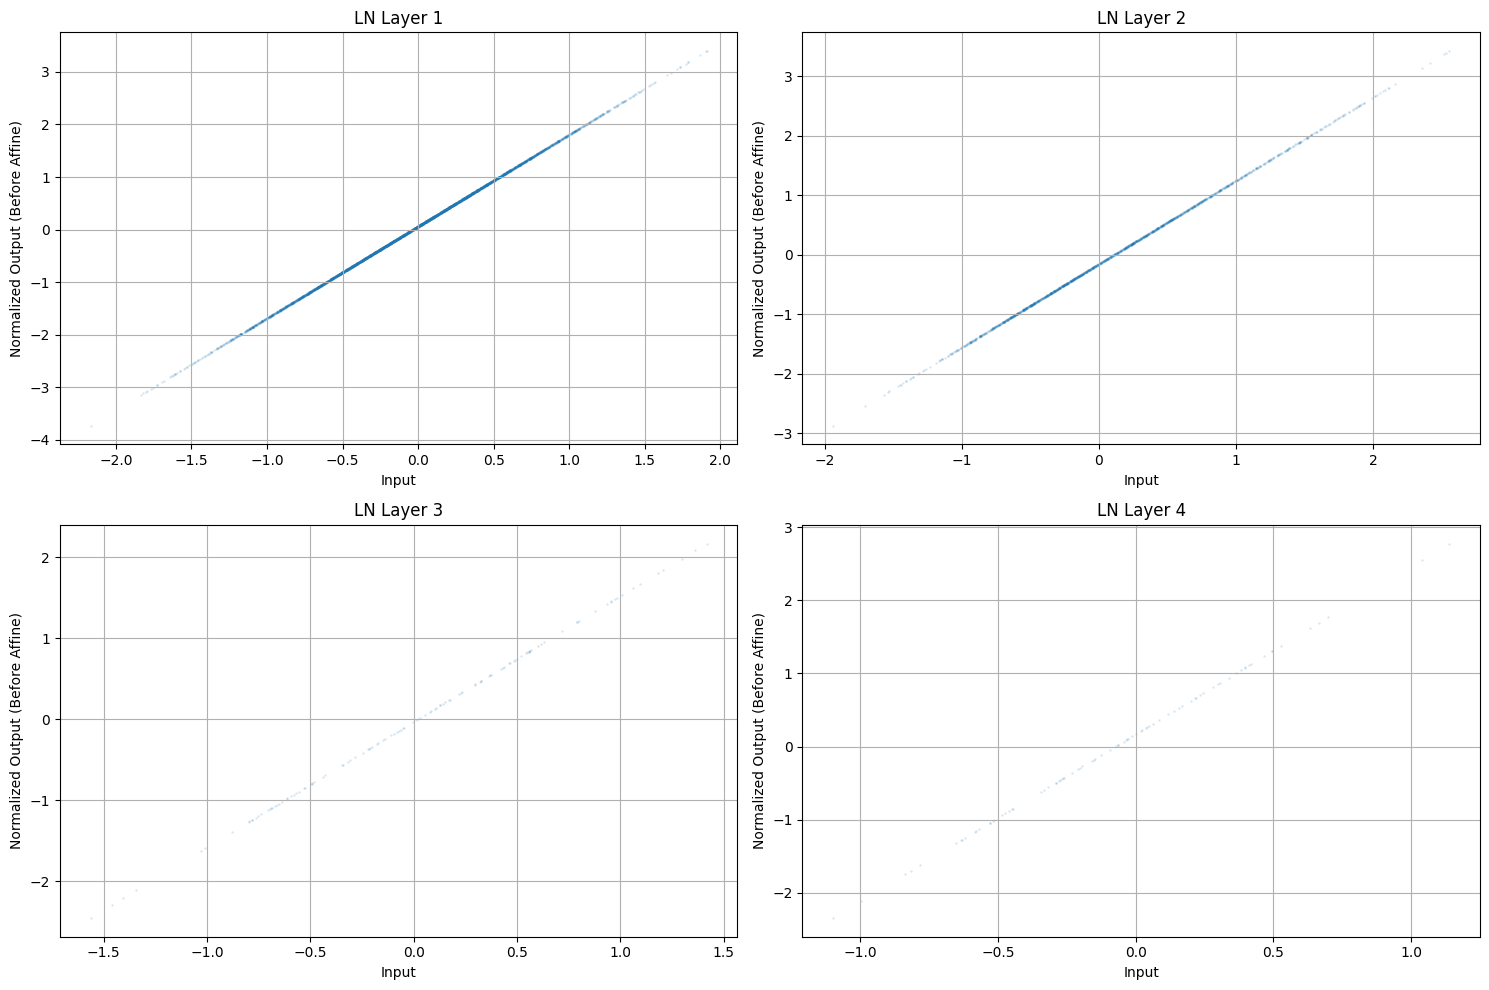

In [25]:
plt.figure(figsize=(15, 10))
for i, (x_ln, y_ln) in enumerate(ln_data):
    x_flat = x_ln.flatten().detach().cpu().numpy()  # Flatten and detach for plotting
    y_flat = y_ln.flatten().detach().cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(x_flat, y_flat, alpha=0.1, s=1)
    plt.xlabel("Input")
    plt.ylabel("Normalized Output (Before Affine)")
    plt.title(f"LN Layer {i + 1}")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# train the model

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
            break


    # accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct
            / total}")

    print(f"Finished epoch {epoch + 1}")
    # epoch loss
    print(f"Epoch loss: {running_loss / len(trainloader)}")

[1,  2000] loss: 2.304
Accuracy: 10.0
Finished epoch 1
Epoch loss: 0.0
[2,  2000] loss: 2.304
Accuracy: 10.0
Finished epoch 2
Epoch loss: 0.0
[3,  2000] loss: 2.304
Accuracy: 10.0
Finished epoch 3
Epoch loss: 0.0
[4,  2000] loss: 2.304
Accuracy: 10.0
Finished epoch 4
Epoch loss: 0.0
[5,  2000] loss: 2.304
Accuracy: 10.0
Finished epoch 5
Epoch loss: 0.0
[6,  2000] loss: 2.304
Accuracy: 10.0
Finished epoch 6
Epoch loss: 0.0
[7,  2000] loss: 2.304
Accuracy: 10.0
Finished epoch 7
Epoch loss: 0.0
[8,  2000] loss: 2.303
Accuracy: 10.0
Finished epoch 8
Epoch loss: 0.0
[9,  2000] loss: 2.304
Accuracy: 10.0
Finished epoch 9
Epoch loss: 0.0
[10,  2000] loss: 2.303
Accuracy: 10.0
Finished epoch 10
Epoch loss: 0.0


In [33]:
plt.figure(figsize=(15, 10))
for i, (x_ln, y_ln) in enumerate(ln_data):
    x_flat = x_ln.flatten().detach().cpu().numpy()  # Flatten and detach for plotting
    y_flat = y_ln.flatten().detach().cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(x_flat, y_flat, alpha=0.1, s=1)
    plt.xlabel("Input")
    plt.ylabel("Normalized Output (Before Affine)")
    plt.title(f"LN Layer {i + 1}")
    plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: too many values to unpack (expected 2)

<Figure size 1500x1000 with 0 Axes>

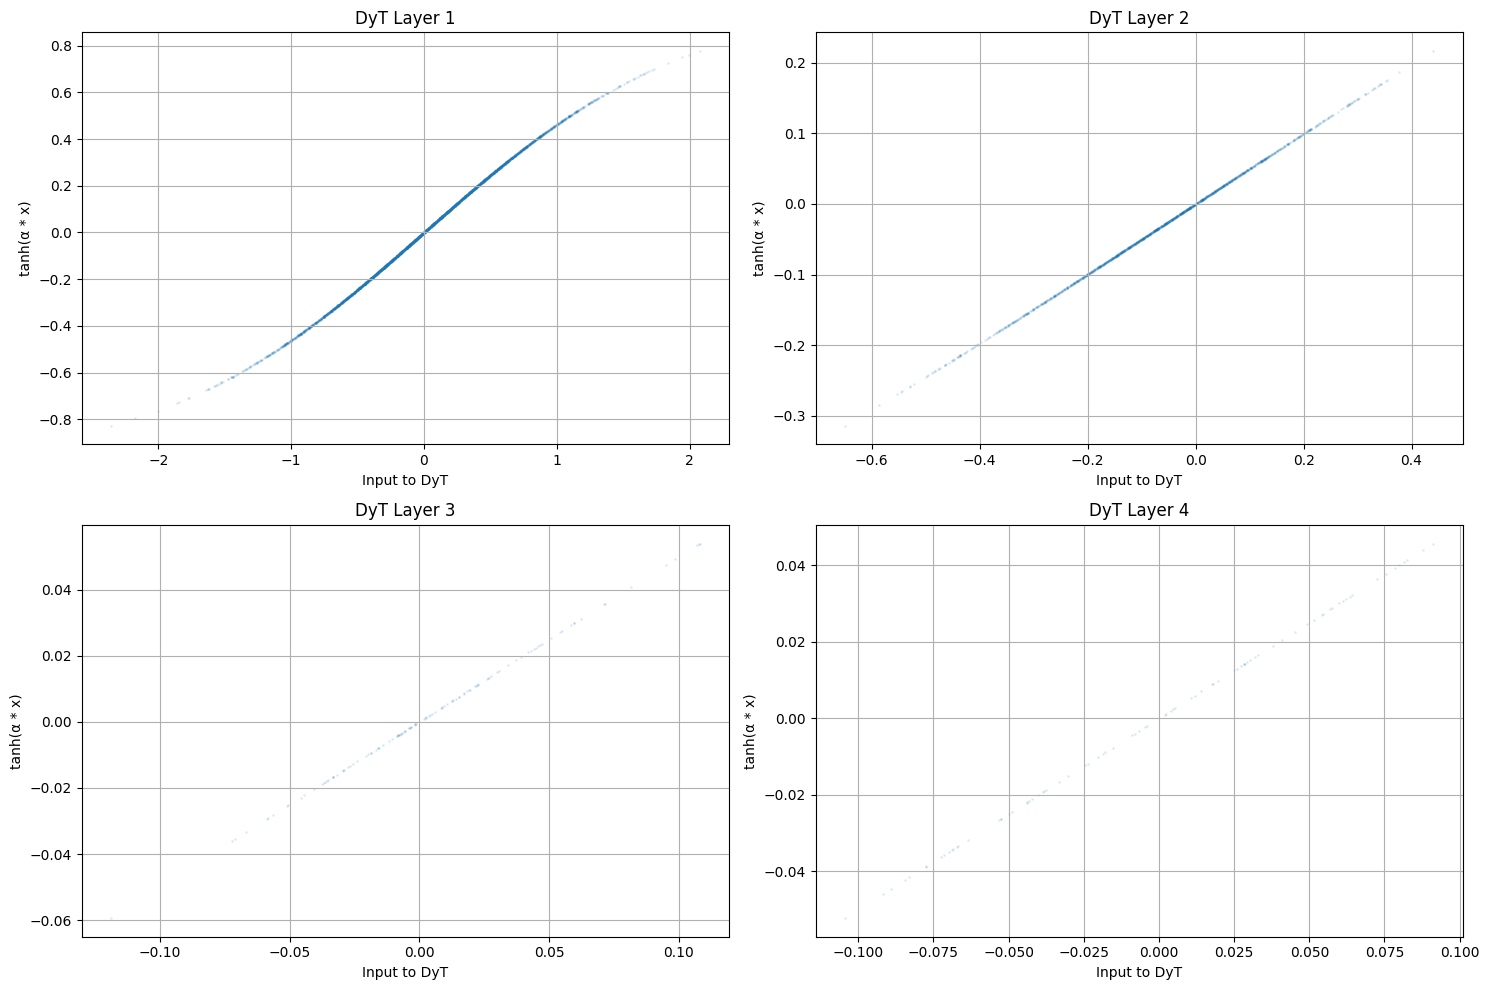

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# DyT Layer
class DyT(nn.Module):
    def __init__(self, C, init_α=0.5):
        super().__init__()
        self.α = nn.Parameter(torch.ones(1) * init_α)
        self.γ = nn.Parameter(torch.ones(C))
        self.β = nn.Parameter(torch.zeros(C))

    def forward(self, x):
        tanh_output = torch.tanh(self.α * x)
        return self.γ * tanh_output + self.β, tanh_output


class DyT(nn.Module):
    def __init__(self, C, init_α=0.5):
        super().__init__()
        self.α = nn.Parameter(torch.ones(1) * init_α)  # Scalar parameter
        self.γ = nn.Parameter(torch.ones(C))           # Shape [C]
        self.β = nn.Parameter(torch.zeros(C))          # Shape [C]

    def forward(self, x):
        tanh_output = torch.tanh(self.α * x)
        if x.dim() == 4:
            # For 4D input [batch_size, C, H, W]
            gamma = self.γ.view(1, -1, 1, 1)  # Reshape to [1, C, 1, 1]
            beta = self.β.view(1, -1, 1, 1)   # Reshape to [1, C, 1, 1]
        elif x.dim() == 2:
            # For 2D input [batch_size, C]
            gamma = self.γ                     # Shape [C]
            beta = self.β                      # Shape [C]
        else:
            raise ValueError(f"Unsupported input dimension: {x.dim()}")
        final_output = gamma * tanh_output + beta
        return final_output, tanh_output

# ResNet with DyT
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.dyt1 = DyT(C=6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dyt2 = DyT(C=16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dyt3 = DyT(C=120)
        self.fc2 = nn.Linear(120, 84)
        self.dyt4 = DyT(C=84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x_dyt1 = x
        x, tanh_dyt1 = self.dyt1(x)
        x = self.pool(F.relu(x))

        x = self.conv2(x)
        x_dyt2 = x
        x, tanh_dyt2 = self.dyt2(x)
        x = self.pool(F.relu(x))

        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x_dyt3 = x
        x, tanh_dyt3 = self.dyt3(x)
        x = F.relu(x)

        x = self.fc2(x)
        x_dyt4 = x
        x, tanh_dyt4 = self.dyt4(x)
        x = F.relu(x)

        x = self.fc3(x)
        dyt_data = [(x_dyt1, tanh_dyt1), (x_dyt2, tanh_dyt2), (x_dyt3, tanh_dyt3), (x_dyt4, tanh_dyt4)]
        return x, dyt_data

# Run and visualize
model = ResNet()
input_data = torch.randn(1, 3, 32, 32)
output, dyt_data = model(input_data)

plt.figure(figsize=(15, 10))
for i, (x_dyt, tanh_dyt) in enumerate(dyt_data):
    x_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_flat = tanh_dyt.flatten().detach().cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(x_flat, tanh_flat, alpha=0.1, s=1)
    plt.xlabel("Input to DyT")
    plt.ylabel("tanh(α * x)")
    plt.title(f"DyT Layer {i + 1}")
    plt.grid(True)
plt.tight_layout()
plt.show()